In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import powerlaw
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [2]:
# Constant definitions
REVIEW_FILE = "Grocery_and_Gourmet_Food.json"
REVIEW_PICKLE = "reviews"
META_FILE = "meta_Grocery_and_Gourmet_Food.json"
META_PICKLE = "meta"
DATA_LOCATION = "data/"
PICKLE_LOCATION = "processed-data/"

In [3]:
def load_pickle(pickle_name):
    with open(PICKLE_LOCATION+pickle_name, 'rb') as file:
        return pickle.load(file)

In [4]:
def save_pickle(result, pickle_name):
    with open(PICKLE_LOCATION+pickle_name, 'wb') as file:
        pickle.dump(result, file)

In [5]:
def read_file(file):
    if file == REVIEW_FILE:
        pickle_name = REVIEW_PICKLE
    elif file == META_FILE:
        pickle_name = META_PICKLE
    else:
        pickle_name = file
    
    try:
        return load_pickle(pickle_name)
    except (FileNotFoundError, EOFError) as e:
        file_df = pd.read_json(DATA_LOCATION+file, lines=True)
        save_pickle(file_df, pickle_name)
        return file_df

In [6]:
def format_reviews(reviews):
    reviews.rename(columns={'overall': 'stars', 'vote': 'upvote'}, inplace=True)
    
    reviews["stars"] = reviews["stars"].astype(int)
    reviews["verified"] = reviews["verified"].astype(bool)
    
    # Cast reviewTime to date
    reviews["reviewTime"] = reviews["reviewTime"].str.replace("^0", "")
    reviews["reviewTime"] = pd.to_datetime(reviews["reviewTime"], format="%m %d, %Y")
    
    # Cast vote to int, while changing NaN values to 0
    #reviews.loc[reviews["vote"].isnull(), "vote"] = "0"
    reviews["upvote"] = reviews["upvote"].str.replace(",", "") # Thousands are separated with commas, we remove them. e.g. 1,881 = 1881
    reviews["upvote"].fillna(0, inplace=True)
    reviews["upvote"] = reviews["upvote"].astype(int)
    
    # transform nan values in reviewText and summary to empty string
    reviews["reviewText"].fillna("", inplace=True)
    reviews["summary"].fillna("", inplace=True)

def format_meta(meta):
    # Not formated: also_view and also_bought, image and five last (feature, ...)
    cols_empty_string = ['description', 'title', 'main_cat', 'brand', 'rank', 'also_view', 'also_buy']
    # Fill na?
    meta.loc[:, cols_empty_string] = meta.loc[:, cols_empty_string].fillna("")
    
    # Map the list representation of category and description to string
    cols_list_to_string = ['category', 'description']
    meta.loc[:, cols_list_to_string] = meta.loc[:, cols_list_to_string].applymap(lambda l: ' '.join(l))
    
    # Verification: meta[(meta['price'].isnull()) | (meta['price'].str.contains('^\$'))].size - meta.size
    meta['price'] = pd.to_numeric(meta['price'].str.replace('$', '', regex=False), errors='coerce')
    
    # Cast date column to date format
    meta['date'] = pd.to_datetime(meta['date'], errors='coerce')

In [7]:
reviews = read_file(REVIEW_FILE)
meta = read_file(META_FILE)

In [8]:
meta_prices = meta["price"][meta["price"].notnull()]
meta_prices[~meta_prices.str.contains("$", regex=False)] # All prices are either NaN or $ something

Series([], Name: price, dtype: object)

In [9]:
format_reviews(reviews)
format_meta(meta)

In [10]:
reviews.head()

,stars,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,upvote,image,style
0,5,True,2013-06-04,ALP49FBWT4I7V,1888861614,Lori,Very pleased with my purchase. Looks exactly l...,Love it,1370304000,0,NaN,NaN
1,4,True,2014-05-23,A1KPIZOCLB9FZ8,1888861614,BK Shopper,Very nicely crafted but too small. Am going to...,Nice but small,1400803200,0,NaN,NaN
2,4,True,2014-05-09,A2W0FA06IYAYQE,1888861614,daninethequeen,still very pretty and well made...i am super p...,"the ""s"" looks like a 5, kina",1399593600,0,NaN,NaN
3,5,True,2014-04-20,A2PTZTCH2QUYBC,1888861614,Tammara,"I got this for our wedding cake, and it was ev...",Would recommend this to a friend!,1397952000,0,NaN,NaN
4,4,True,2014-04-16,A2VNHGJ59N4Z90,1888861614,LaQuinta Alexander,It was just what I want to put at the top of m...,Topper,1397606400,0,NaN,NaN


In [11]:
reviews.isnull().sum()

stars                   0
verified                0
reviewTime              0
reviewerID              0
asin                    0
reviewerName          355
reviewText              0
summary                 0
unixReviewTime          0
upvote                  0
image             5003225
style             2798836
dtype: int64

In [12]:
meta.head()

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,"Grocery & Gourmet Food Dairy, Cheese & Eggs Ch...",BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS Statem...,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(","[B0000D9MYM, B0000D9MYL, B00ADHIGBA, B00H9OX59...",Grocery,41.91,0681727810,,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1,Grocery & Gourmet Food Cooking & Baking Sugar ...,"Shipped from UK, please allow 10 to 21 busines...",Trim Healthy Mama Xylitol,,"315,867inGroceryGourmetFood(",,Grocery,NaN,0853347867,"[B01898YHXK, B01BCM6LAC, B00Q4OL47O, B00Q4OL5Q...",[https://images-na.ssl-images-amazon.com/image...,NaT,NaN,NaN,NaN,NaN,NaN
2,Grocery & Gourmet Food Cooking & Baking Frosti...,Jazz up your cakes with a sparkling monogram f...,Letter C - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in ...",[B07DXN65TF],Amazon Home,29.95,1888861118,,NaN,2010-09-21,NaN,NaN,NaN,NaN,NaN
3,Grocery & Gourmet Food Cooking & Baking Frosti...,"Large Letter - Height 4.75""",Letter H - Swarovski Crystal Monogram Wedding ...,Other,">#832,581 in Kitchen & Dining (See Top 100 in ...",,Amazon Home,11.45,1888861517,,NaN,2011-09-11,"[Large Letter - Height 4.75""]",NaN,NaN,NaN,NaN
4,Grocery & Gourmet Food Cooking & Baking Frosti...,"4.75""",Letter S - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#590,999 in Kitchen & Dining (See Top 100 in ...",,Amazon Home,15.00,1888861614,,NaN,2011-09-11,"[4.75"" height]",NaN,NaN,NaN,NaN


In [13]:
meta.isnull().sum()

category             0
description          0
title                0
brand                0
rank                 0
also_view            0
main_cat             0
price           155184
asin                 0
also_buy             0
image           136995
date            277650
feature         270835
details          13886
similar_item    286953
tech1           286465
fit             287205
dtype: int64

## Plot features

In [14]:
reviews.describe()

,stars,unixReviewTime,upvote
count,5.074160e+06,5.074160e+06,5.074160e+06
mean,4.314708e+00,1.446592e+09,8.295479e-01
std,1.249303e+00,6.227839e+07,1.206719e+01
min,1.000000e+00,9.613728e+08,0.000000e+00
25%,4.000000e+00,1.416096e+09,0.000000e+00
50%,5.000000e+00,1.456790e+09,0.000000e+00
75%,5.000000e+00,1.491782e+09,0.000000e+00
max,5.000000e+00,1.538870e+09,1.217400e+04


In [15]:
def plot_bar_distribution(data, title, xlabel, ylabel, yscale='linear', width=0.8, figsize=(12, 8), categorical=False):
    counts = np.bincount(data)
    values = np.nonzero(counts)[0]
    counts = counts[values]
    
    plt.figure(figsize=figsize)
    plt.bar(values, counts, width=width)
    if categorical:
        plt.xticks(values)
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.yscale(yscale)
    plt.show()

In [16]:
def plot_ccdf_power_law(data, title, xlabel, ylabel, xmin=0, discrete=True, figsize=(10,8)):
    fit = powerlaw.Fit(data, xmin=xmin, discrete=discrete)
    plt.figure(figsize=figsize)
    ax = plt.gca()
    fit.power_law.plot_ccdf(color='b', linestyle='--', label='fit ccdf', ax=ax)
    fit.plot_ccdf(color='b', label='actual ccdf', ax=ax)
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.legend()
    plt.show() 

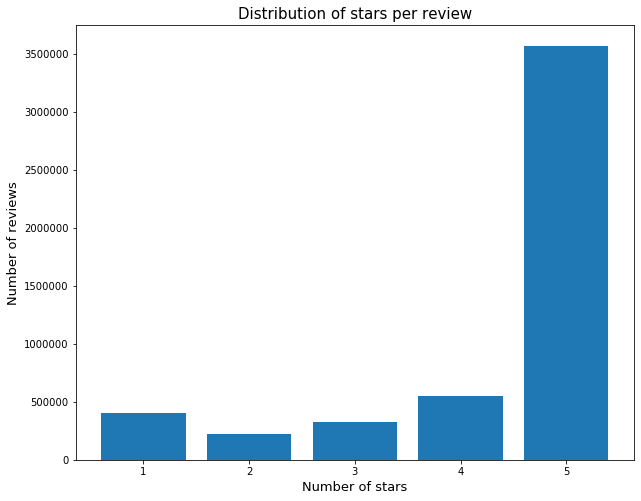

In [17]:
plot_bar_distribution(reviews['stars'], title="Distribution of stars per review", xlabel="Number of stars", ylabel="Number of reviews", figsize=(10,8), categorical=True)

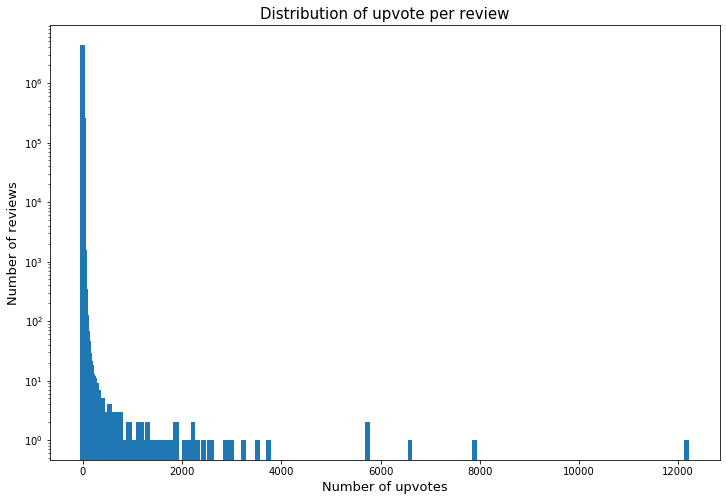

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/lulu/.venv/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
/home/lulu/.venv/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in true_divide
  (CDF_diff**2) /


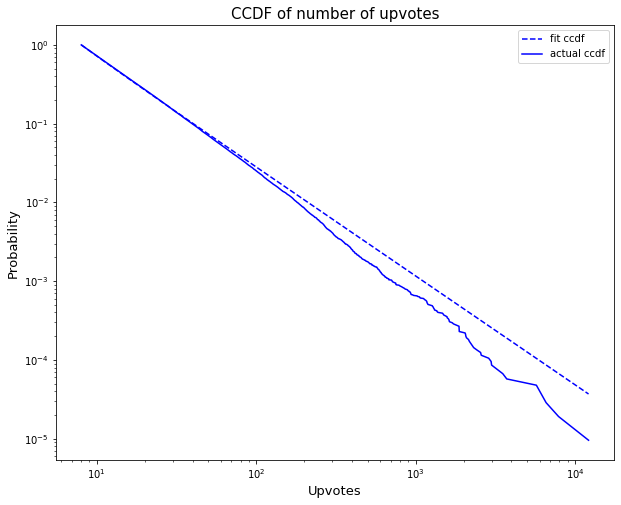

In [18]:
plot_bar_distribution(reviews['upvote'], title="Distribution of upvote per review", xlabel="Number of upvotes", ylabel="Number of reviews", yscale="log", width=100)
plot_ccdf_power_law(reviews['upvote'], title="CCDF of number of upvotes", xlabel="Upvotes", ylabel="Probability")

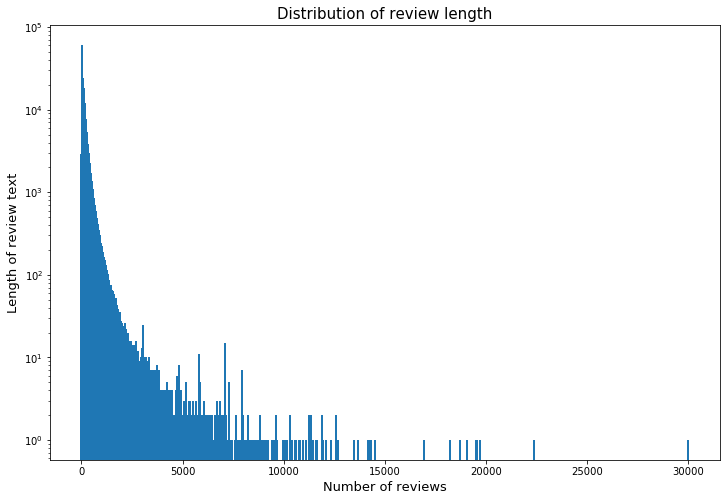

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


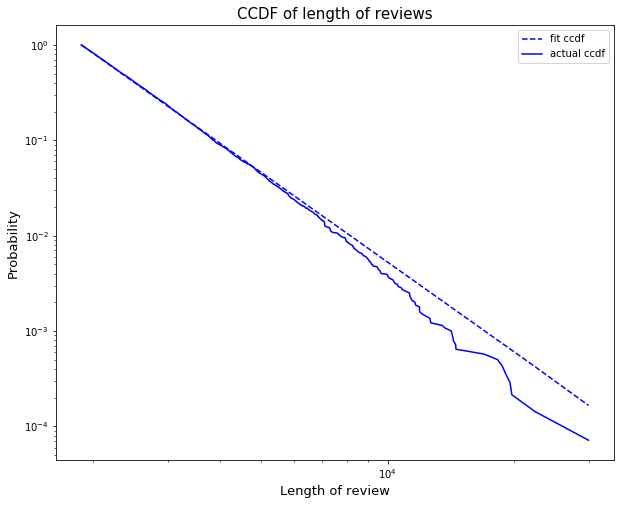

In [19]:
plot_bar_distribution(reviews['reviewText'].str.len(), title="Distribution of review length", xlabel="Number of reviews", ylabel="Length of review text", yscale="log", width=100)
plot_ccdf_power_law(reviews['reviewText'].str.len(), title="CCDF of length of reviews", xlabel="Length of review", ylabel="Probability")

In [20]:
reviews_per_date = reviews[['reviewTime']].copy()
reviews_per_date = pd.DataFrame(reviews_per_date.groupby('reviewTime').size(), columns=['count'])
reviews_per_date.sort_index(inplace=True)

tools = "pan, wheel_zoom"
source = ColumnDataSource(reviews_per_date)

p = figure(plot_width=1400, plot_height=800, tools=tools, x_axis_type="datetime")
p.line('reviewTime', 'count', source=source)
show(p)

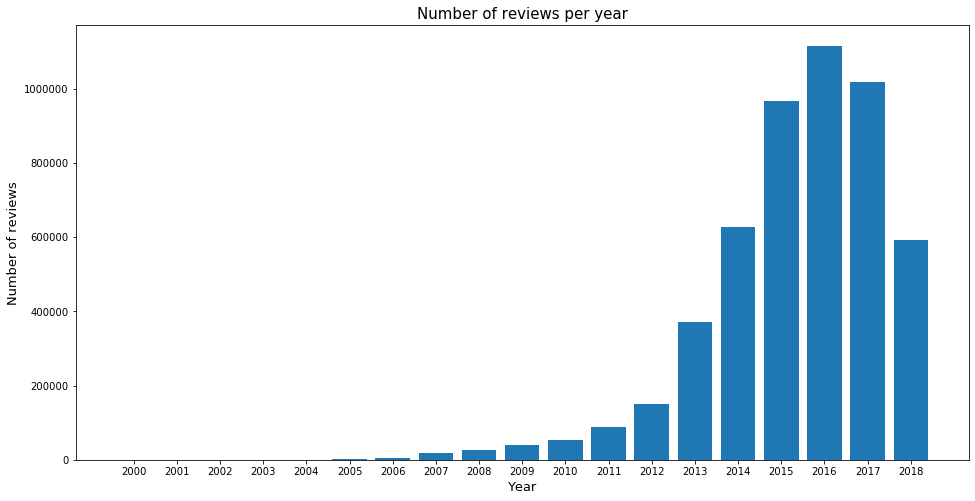

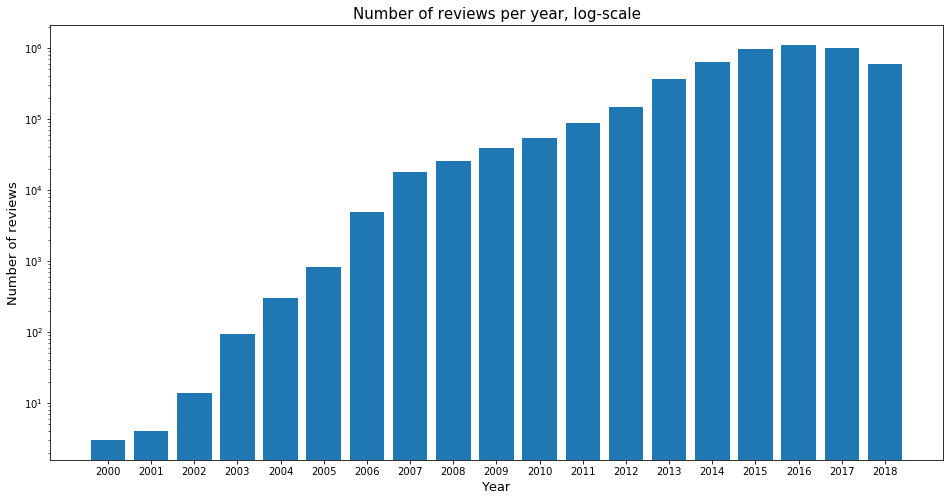

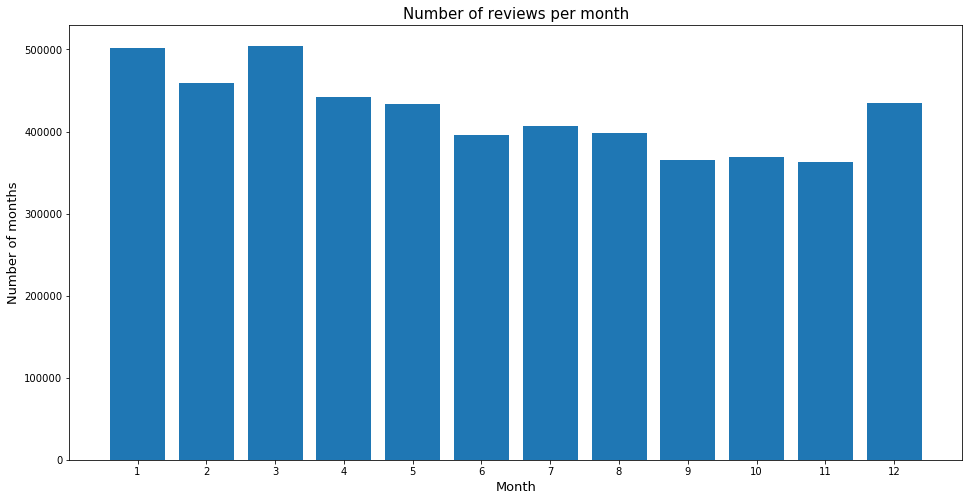

In [24]:
reviews_year = reviews['reviewTime'].map(lambda date: date.year)
plot_bar_distribution(reviews_year, title="Number of reviews per year", xlabel="Year", ylabel="Number of reviews", figsize=(16, 8), categorical=True)
plot_bar_distribution(reviews_year, title="Number of reviews per year, log-scale", xlabel="Year", ylabel="Number of reviews", yscale="log", figsize=(16, 8), categorical=True)

reviews_month = reviews['reviewTime'].map(lambda date: date.month)
plot_bar_distribution(reviews_month, title="Number of reviews per month", xlabel="Month", ylabel="Number of months", figsize=(16, 8), categorical=True)

In [22]:
meta

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,"Grocery & Gourmet Food Dairy, Cheese & Eggs Ch...",BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS Statem...,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(","[B0000D9MYM, B0000D9MYL, B00ADHIGBA, B00H9OX59...",Grocery,41.91,0681727810,,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1,Grocery & Gourmet Food Cooking & Baking Sugar ...,"Shipped from UK, please allow 10 to 21 busines...",Trim Healthy Mama Xylitol,,"315,867inGroceryGourmetFood(",,Grocery,NaN,0853347867,"[B01898YHXK, B01BCM6LAC, B00Q4OL47O, B00Q4OL5Q...",[https://images-na.ssl-images-amazon.com/image...,NaT,NaN,NaN,NaN,NaN,NaN
2,Grocery & Gourmet Food Cooking & Baking Frosti...,Jazz up your cakes with a sparkling monogram f...,Letter C - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in ...",[B07DXN65TF],Amazon Home,29.95,1888861118,,NaN,2010-09-21,NaN,NaN,NaN,NaN,NaN
3,Grocery & Gourmet Food Cooking & Baking Frosti...,"Large Letter - Height 4.75""",Letter H - Swarovski Crystal Monogram Wedding ...,Other,">#832,581 in Kitchen & Dining (See Top 100 in ...",,Amazon Home,11.45,1888861517,,NaN,2011-09-11,"[Large Letter - Height 4.75""]",NaN,NaN,NaN,NaN
4,Grocery & Gourmet Food Cooking & Baking Frosti...,"4.75""",Letter S - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#590,999 in Kitchen & Dining (See Top 100 in ...",,Amazon Home,15.00,1888861614,,NaN,2011-09-11,"[4.75"" height]",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287204,"Grocery & Gourmet Food Jams, Jellies & Sweet S...",Caffarel fruit jellies are a product of Italy....,"Caffarel Fruit Jellies, Organic Assorted, 200 ...",Caffarel,"369,384inGroceryGourmetFood(",,Grocery,NaN,B01HJFBN9A,"[B01HULC3TC, B07C8L4NWL, B014UTG6D6, B01M3UOLAP]",NaN,NaT,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
287205,Grocery & Gourmet Food Condiments & Salad Dres...,Hampton Creeks Just Mayo Truffle makes fancy f...,"HAMPTON CREEK Spo Just Truffle Mayo, 12 Ounce",Hampton Creek,"113,710inGroceryGourmetFood(",,Grocery,10.89,B01HJFC704,"[B00WNAEX2Q, B071LD7PMJ, B01HJF6FRA, B072HG8GF...",NaN,NaT,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
287206,Grocery & Gourmet Food Condiments & Salad Dres...,Nothing compares with the classically zesty fl...,"HAMPTON CREEK Just Ranch Dressing, 12 Fluid Ounce",Hampton Creek,"21,731inGroceryGourmetFood(",,Grocery,10.95,B01HJF6FRA,"[B071LD7PMJ, B00KOHNX6C, B00OVN2F64, B01HJEHE9...",NaN,NaT,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
287207,"Grocery & Gourmet Food Herbs, Spices & Seasoni...",,Gourmet Pure Vanilla Bean Pastes - Organically...,Heilala Vanilla,472inGroceryGourmetFood(,,Grocery,14.97,B01HJHSVG6,"[B00DUF219A, B01HJHX9ZO, B07K4K26PQ, B000H7ENQ...",[https://images-na.ssl-images-amazon.com/image...,NaT,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Size: <s...",NaN,NaN,NaN


## Time series of number of reviews

In [ ]:
r = reviews.loc[:10000]
times = pd.DataFrame(r[['asin', 'reviewTime']].groupby(['asin', pd.Grouper(key='reviewTime', freq='W')]).size(), columns=['count'])
times = times.reset_index()
display(times)
plt.figure(figsize=(32, 8))
for asin in times.index.get_level_values('asin'):
    plt.hist(times, bins=18*12, label=str(times.index[i]))

plt.legend()

## Word2Vec for veganism

In [ ]:
from gensim.models import Word2Vec, KeyedVectors

# reference of model: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing
# Taken from https://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/
google_model = KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
christmas_words = ['present', 'gift', 'snow', 'turkey', 'gingerbread', 'christmas', 'Christmas', 'family', 'dinner', 'stuff', 'stuffing', 'cranberry', 'cranberries', 'champagne', 'candy', 'cane', 'pie']
veg_words = ['vegan', 'vegetarian', 'organic', 'raw', 'health', 'green', 'bean', 'soy', 'tofu', 'tempeh', 'granola', 'hummus', 'Vegan', 'gluten_free', 'vegans', 'vegetarians', 'vegeterian', 'nonmeat', 'avocado']

In [ ]:
def compare_review(model, review_texts, word_set):
    for review_text in review_texts:
        valid_text = [word for word in review_text if word in model.vocab]
        if len(valid_text) == 0:
            continue
        sim = model.n_similarity(valid_text, word_set)
        if sim > 0.4:
            print(sim, ":\n", valid_text)

In [ ]:
google_model.most_similar(['christmas', 'food', 'meal', 'turkey', 'gravy', 'stuffing'])

In [ ]:
google_model.most_similar(positive=['vegan', 'food'], negative=['meat'])

## Lemmtization of the reviewText for analysis

In [86]:
import string
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger');

def remove_punctuation(s):
    punct_chars = string.punctuation
    translator_punct = s.maketrans(punct_chars, ' ' * len(punct_chars))
    
    return s.translate(translator_punct)

def remove_stopwords(s):
    stopwords_np = np.array(stopwords.words('english'))
    words = np.array(s.split())
    words_filtered = words[~np.in1d(words, stopwords_np)]
    
    return ' '.join(words_filtered)

def transform_tag(tag):
    tag_prefix = tag[0].lower()
    if tag_prefix in ['n', 'r', 'v', 'j']:
        return 'a' if tag_prefix == 'j' else tag_prefix
    else:
        return 'n'

def lemmatize(t):
    t = remove_punctuation(t)
    t = remove_stopwords(t)
    t_token = word_tokenize(t)
    t_tags = pos_tag(t_token)
    print(t_tags)
    t_lemm = [lemmatizer.lemmatize(w, transform_tag(t)) for w, t in t_tags]
    return ' '.join(t_lemm)

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno -3] Temporary failure in name resolution>


In [87]:
print('Example of lemmatizing pipeline')
testpd = pd.DataFrame(np.array([['I tried to stop some words to see  the lemmatizing. \nWords word!! alias-alias to and'], 
                                ['Here we\'ll see.']]), columns=['raw'])
testpd['lemmatized'] = testpd['raw'].apply(lemmatize)
testpd

Example of lemmatizing pipeline
[('I', 'PRP'), ('tried', 'VBD'), ('stop', 'JJ'), ('words', 'NNS'), ('see', 'VBP'), ('lemmatizing', 'JJ'), ('Words', 'NNP'), ('word', 'NN'), ('alias', 'NN'), ('alias', 'NN')]
[('Here', 'RB'), ('see', 'VB')]


,raw,lemmatized
0,I tried to stop some words to see the lemmati...,I try stop word see lemmatizing Words word ali...
1,Here we'll see.,Here see


In [ ]:
# Very slow, didn't run yet
reviews["reviewTextLemma"] = reviews['reviewText'].apply(lemmatize)
reviews